In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

2024-10-24 19:33:51.302276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 19:33:51.325307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 19:33:51.332004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 19:33:51.350983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
from google.cloud import storage
import os
#import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.ndimage import map_coordinates
from skimage.color import rgb2gray
from skimage.io import imread
import numpy as np

#import cv2
import datetime
import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling1D

In [3]:
from medmnist import ChestMNIST
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [4]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [5]:
client = storage.Client()
# marketplace-p115jwl6/MedMNIST/120/

bucket_name = 'marketplace-p115jwl6'  

bucket = client.get_bucket(bucket_name)
dataset_folder="MedMNIST/120/"

In [6]:
blobs = bucket.list_blobs(prefix=dataset_folder)
for blob in blobs:  
    file_name = blob.name #.split('/')[-1]
    if "128" in file_name:
        print(file_name)

MedMNIST/120/artifactFiles/bloodmnist_128.npz
MedMNIST/120/artifactFiles/breastmnist_128.npz
MedMNIST/120/artifactFiles/chestmnist_128.npz
MedMNIST/120/artifactFiles/octmnist_128.npz
MedMNIST/120/artifactFiles/organamnist_128.npz
MedMNIST/120/artifactFiles/organcmnist_128.npz
MedMNIST/120/artifactFiles/organsmnist_128.npz
MedMNIST/120/artifactFiles/pathmnist_128.npz
MedMNIST/120/artifactFiles/pneumoniamnist_128.npz
MedMNIST/120/artifactFiles/retinamnist_128.npz
MedMNIST/120/artifactFiles/tissuemnist_128.npz


In [7]:
image_path="MedMNIST/120/artifactFiles/chestmnist_128.npz"
output_dir="ch12_ds"

In [8]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [9]:
blob1 = bucket.blob(image_path)
local_file_path = os.path.join(output_dir, 'chestmnist_128.npz')

In [10]:
#blob1.download_to_filename(local_file_path)

In [11]:
print(f"Downloaded: {local_file_path}")

Downloaded: ch12_ds/chestmnist_128.npz


In [12]:
# Load the NPZ file
data = np.load(local_file_path)
print(data)


NpzFile 'ch12_ds/chestmnist_128.npz' with keys: train_images, train_labels, val_images, val_labels, test_images...


In [13]:
# Access the different sets
train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
test_images = data['test_images']
test_labels = data['test_labels']
# Explore the data
print(train_images.shape)  # Output: (5500, 128, 128, 1)
print(train_labels.shape)  # Output: (5500,)
print(train_images[0].min(), train_images[0].max())  # Output: 0.0 1.0
print(test_images.shape)
print(val_images.shape)

(78468, 128, 128)
(78468, 14)
0 245
(22433, 128, 128)
(11219, 128, 128)


In [14]:
train_labels[np.random.choice(range(500))]
#np.random.choice[range(500)]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [15]:
type(train_labels)

numpy.ndarray

In [16]:
# Analysis labels ( a lot of records with all 0!!!) -> Unbalance datasets
train_labels_df = pd.DataFrame(train_labels)

class_counts = train_labels_df.value_counts()

print("Class frequencies:")
print(class_counts)

Class frequencies:
0  1  2  3  4  5  6  7  8  9  10  11  12  13
0  0  0  0  0  0  0  0  0  0  0   0   0   0     42405
         1  0  0  0  0  0  0  0   0   0   0      6663
1  0  0  0  0  0  0  0  0  0  0   0   0   0      2942
0  0  1  0  0  0  0  0  0  0  0   0   0   0      2730
      0  0  0  1  0  0  0  0  0   0   0   0      1883
                                                ...  
1  1  1  0  0  0  0  0  1  1  0   0   1   0         1
                     1  0  0  0   0   0   0         1
               1  0  0  0  0  0   1   0   0         1
            1  0  0  0  0  0  0   0   0   0         1
                                      1   0         1
Name: count, Length: 682, dtype: int64


In [17]:
# Resize the images
#train_images_resized = tf.image.resize(train_images, (128, 128))
#test_images_resized = tf.image.resize(test_images, (128, 128))

In [18]:
print (train_labels.shape)
print (train_labels)

(78468, 14)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [38]:
# Define hyperparameters
input_shape = (128,128, 1)  # Assuming 28x28 grayscale images
num_classes = 14  # Updated to 14 output classes

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),  # Increased number of neurons
    Dropout(0.5),  # Add dropout for regularization    
    Dense(num_classes, activation='sigmoid')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 14)             │        14,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,799,054 (98.42 MB)

 Trainable params: 25,798,606 (98.41 MB)

 Non-trainable params: 448 (1.75 KB)

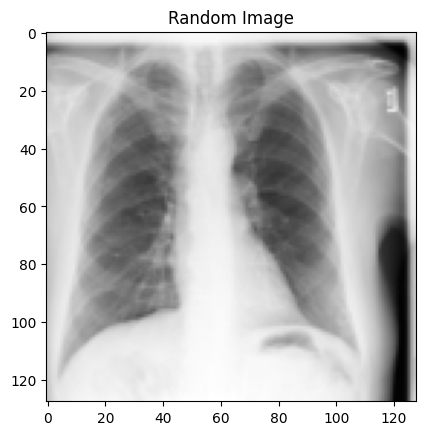

In [20]:
# Display a random image
random_index = np.random.randint(len(train_images))
plt.imshow(train_images[random_index], cmap='gray')
plt.title('Random Image')
plt.show()



Shape of train_images: (78468, 128, 128)
Data type: uint8
Minimum pixel value: 0
Maximum pixel value: 255


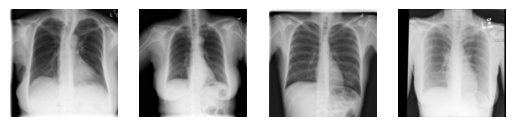

In [21]:
# Explore the dataset
print('Shape of train_images:', train_images.shape)
print('Data type:', train_images.dtype)
print('Minimum pixel value:', train_images.min())
print('Maximum pixel value:', train_images.max())

# Visualize multiple images
num_images_to_display = 4
fig, axs = plt.subplots(1, num_images_to_display)

for i in range(num_images_to_display):
    axs[i].imshow(train_images[i], cmap='gray')
    axs[i].axis('off')

plt.show()

In [22]:
# Normalize pixel values (if necessary)
train_normalized_images = train_images / 255.0
test_normalized_images = test_images/ 255.0
val_normalized_images = val_images / 255.0

In [31]:
print (train_normalized_images.shape)
print(train_labels.shape)
print (test_normalized_images.shape)
print(test_labels.shape)
print (val_normalized_images.shape)
print(val_labels.shape)

(78468, 128, 128)
(78468, 14)
(22433, 128, 128)
(22433, 14)
(11219, 128, 128)
(11219, 14)


In [58]:
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

#model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])


In [59]:
history = model.fit(train_normalized_images,train_labels, epochs=1)

2453/2453 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.6432 - loss: 69711.2812


In [61]:
history = model.fit(train_normalized_images,train_labels, epochs=1,  batch_size=128)

614/614 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6423 - loss: 20297.1055


In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
model.fit(train_normalized_images, train_labels, epochs=1,batch_size=128)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 128
'y' sizes: 78468


In [ ]:
# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
    tf.config.set_visible_devices([tf.config.list_physical_devices('GPU')[0]], 'GPU')
else:
    print("Using CPU")

1227/1227 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.1281 - loss: 2476240128.0000


In [ ]:
with tf.device('/cpu:0'):  # Force training on CPU
    model.fit(train_normalized_images, train_labels, epochs=1, batch_size=16)